# 基于昇思MindSpore+Orangepi AIpro的FCN图像语义分割

功能：使用基于昇思MindSpore框架开发的FCN模型对输入图片进行语义分割。  
样例输入：原始图片。  
样例输出：与输入大小相同的图像，输出图像的每个像素对应了输入图像每个像素的类别。

# 前期准备

* 基础镜像的样例目录中已包含转换后的om模型以及测试图片，如果直接运行，可跳过此步骤。如果需要重新转换模型，可以参考下面的步骤。
* **建议在Linux服务器或者虚拟机转换该模型。**
* 为了能进一步优化模型推理性能，我们需要将其转换为om模型进行使用；**转换指导详见全流程实验指导。**

# 模型推理实现

* 注意：本案例在离线推理的过程中可能会出现内存不足的问题，可以根据情况查看FAQ文档中的解决方案。

### 1. 导入三方库

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mindspore.dataset as ds

import acl
import acllite_utils as utils
from acllite_model import AclLiteModel
from acllite_resource import resource_list

### 2. 定义acllite资源初始化与去初始化类

In [2]:
class AclLiteResource:
    """
    AclLiteResource
    """
    def __init__(self, device_id=0):
        self.device_id = device_id
        self.context = None
        self.stream = None
        self.run_mode = None
        
    def init(self):
        """
        init resource
        """
        print("init resource stage:")
        ret = acl.init()

        ret = acl.rt.set_device(self.device_id)
        utils.check_ret("acl.rt.set_device", ret)

        self.context, ret = acl.rt.create_context(self.device_id)
        utils.check_ret("acl.rt.create_context", ret)

        self.stream, ret = acl.rt.create_stream()
        utils.check_ret("acl.rt.create_stream", ret)

        self.run_mode, ret = acl.rt.get_run_mode()
        utils.check_ret("acl.rt.get_run_mode", ret)

        print("Init resource success")

    def __del__(self):
        print("acl resource release all resource")
        resource_list.destroy()
        if self.stream:
            print("acl resource release stream")
            acl.rt.destroy_stream(self.stream)

        if self.context:
            print("acl resource release context")
            acl.rt.destroy_context(self.context)

        print("Reset acl device ", self.device_id)
        acl.rt.reset_device(self.device_id)
        print("Release acl resource success")

### 3. 数据预处理
由于PASCAL VOC 2012数据集中图像的分辨率大多不一致，无法放在一个tensor中，故输入前需做标准化处理

In [3]:
class SegDataset:
    def __init__(self,
                 image_mean,
                 image_std,
                 data_file='',
                 batch_size=32,
                 crop_size=512,
                 max_scale=2.0,
                 min_scale=0.5,
                 ignore_label=255,
                 num_classes=21,
                 num_readers=2,
                 num_parallel_calls=4):

        self.data_file = data_file
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.image_mean = np.array(image_mean, dtype=np.float32)
        self.image_std = np.array(image_std, dtype=np.float32)
        self.max_scale = max_scale
        self.min_scale = min_scale
        self.ignore_label = ignore_label
        self.num_classes = num_classes
        self.num_readers = num_readers
        self.num_parallel_calls = num_parallel_calls
        max_scale > min_scale

    def preprocess_dataset(self, image, label):
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        image_out = (image_out - self.image_mean) / self.image_std
        out_h, out_w = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = out_h - new_h, out_w - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        offset_h = np.random.randint(0, out_h - self.crop_size + 1)
        offset_w = np.random.randint(0, out_w - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]
        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]
        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        label_out = label_out.astype("int32")
        return image_out, label_out

    def get_dataset(self):
        ds.config.set_numa_enable(True)
        dataset = ds.MindDataset(self.data_file, columns_list=["data", "label"],
                                 shuffle=True, num_parallel_workers=self.num_readers)
        transforms_list = self.preprocess_dataset
        dataset = dataset.map(operations=transforms_list, input_columns=["data", "label"],
                              output_columns=["data", "label"],
                              num_parallel_workers=self.num_parallel_calls)
        dataset = dataset.shuffle(buffer_size=self.batch_size * 10)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset

### 4. 前处理、推理、后处理所需要的函数

In [ ]:
from download import download

# 获取数据集
dataset_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/07-FCN/data.zip"
download(dataset_url, "./", kind="zip", replace=True)

# 获取模型om文件
model_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/07-FCN/FCN8s.zip"
download(model_url, "./", kind="zip", replace=True)

In [4]:
# 定义处理数据集的参数
IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "data/VOC_mindrecord"

# 定义模型推理参数
eval_batch_size = 1
crop_size = 512
min_scale = 0.5
max_scale = 2.0
ignore_label = 255
num_classes = 21

@utils.display_time
def pre_process():
    """
    image preprocess
    """
    # 实例化Dataset
    dataset = SegDataset(image_mean=IMAGE_MEAN,
                         image_std=IMAGE_STD,
                         data_file=DATA_FILE,
                         batch_size=eval_batch_size,
                         crop_size=crop_size,
                         max_scale=max_scale,
                         min_scale=min_scale,
                         ignore_label=ignore_label,
                         num_classes=num_classes,
                         num_readers=2,
                         num_parallel_calls=4)

    dataset = dataset.get_dataset()
    return dataset

# 图片推理
@utils.display_time
def inference(dataset, model):
    """
    model inference
    """
    show_data = next(dataset.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    mask_images = show_data["label"].reshape([1, 512, 512])
    show_images = np.clip(show_images, 0, 1)
    result = model.execute([show_data["data"].asnumpy(), ])
    res = result[0].argmax(axis=1)
    return res ,show_images

@utils.display_time
def post_process(res, show_images):
    """
    post process
    """
    plt.figure(figsize=(8, 5))
    plt.subplot(2, 1, 1)
    plt.imshow(show_images[0].transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.subplot(2, 1, 2)
    plt.imshow(res.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.show()

### 5. 构造主函数，串联整个代码逻辑

In [5]:
path = os.getcwd()
def main():
    # acl初始化
    acl_resource = AclLiteResource()
    acl_resource.init()
    # 加载模型
    model_path = os.path.join(path, "FCN8s.om")
    model = AclLiteModel(model_path)
    # preprocess
    dataset = pre_process()   # 前处理
    # inference
    res, show_images = inference(dataset, model)   # 推理
    # postprocess
    post_process(res, show_images)  # 后处理    

### 6. 运行
运行完成后，会显示推理前和推理后的图片，如下所示。

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 22020096
Create model output dataset success
Init model resource success
in pre_process, use time:0.004704952239990234
in inference, use time:0.6202666759490967


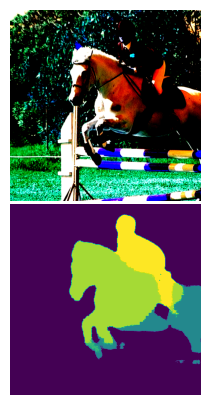

in post_process, use time:15.616747617721558
acl resource release all resource
AclLiteModel release source success
acl resource release stream
acl resource release context
Reset acl device  0
Release acl resource success


In [6]:
main()

其中，除了acl相关资源初始化和释放的信息外，“in pre_process, use time”表示前处理耗时，“in inference, use time”表示推理耗时，“in post_process, use time”表示后处理耗时，单位都为秒。

# 样例总结

我们来回顾一下以上代码，可以包括以下几个步骤：
1. 初始化acl资源：在调用acl相关资源时，必须先初始化AscendCL，否则可能会导致后续系统内部资源初始化出错。  
2. 对图片进行前处理：使得模型正常推理。  
3. 推理：利用AclLiteModel.execute接口对图片进行推理。  
4. 对推理结果进行后处理：使得图片正常画出。  
5. 可视化图片：利用plt将结果画出。